# Linear Regression

* [Pairs trading](https://www.quantopian.com/posts/pairs-trading-algorithm-1) is a famous technique in algorithmic trading that plays two stocks against each other.
* For this to work, stocks must be correlated (cointegrated).
* One common example is the price of gold (GLD) and the price of gold mining operations (GFI).

In [16]:
%matplotlib inline
import pandas as pd
import numpy as np
import theano
import pymc3 as pm
import seaborn as sns
from statsmodels.tsa.stattools import coint
import matplotlib.pyplot as plt
import pandas_datareader.data as web

## Simple Linear Regression Demo

### Artificial Data

In [2]:
size = 200
true_intercept = 1
true_slope = 2

x = np.linspace(0, 1, size)
true_regression_line = true_intercept + true_slope * x
y = true_regression_line + np.random.normal(scale=.5, size=size)

x_shared = theano.shared(x)

### Model Definition

In [3]:
with pm.Model() as linear_regression: # model specification

    # Define priors
    sd = pm.HalfCauchy('sigma', beta=10, testval=1) # unique name for each variable
    intercept = pm.Normal('intercept', 0, sd=20)
    slope = pm.Normal('slope', 0, sd=20)

    # Define likelihood
    likelihood = pm.Normal('y', mu=intercept + slope * x_shared, sd=sd, observed=y)

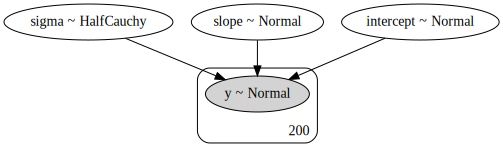

In [4]:
pm.model_to_graphviz(linear_regression)

### HMC Inference

In [5]:
with linear_regression:
    # Inference
    trace = pm.sample(draws=2500, # draw 2500 samples from posterior using NUTS sampling
                      tune=1000, 
                      cores=4) 

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [slope, intercept, sigma]
Sampling 4 chains, 0 divergences: 100%|██████████| 14000/14000 [00:03<00:00, 4385.08draws/s]


### Posterior Parameter Distributions

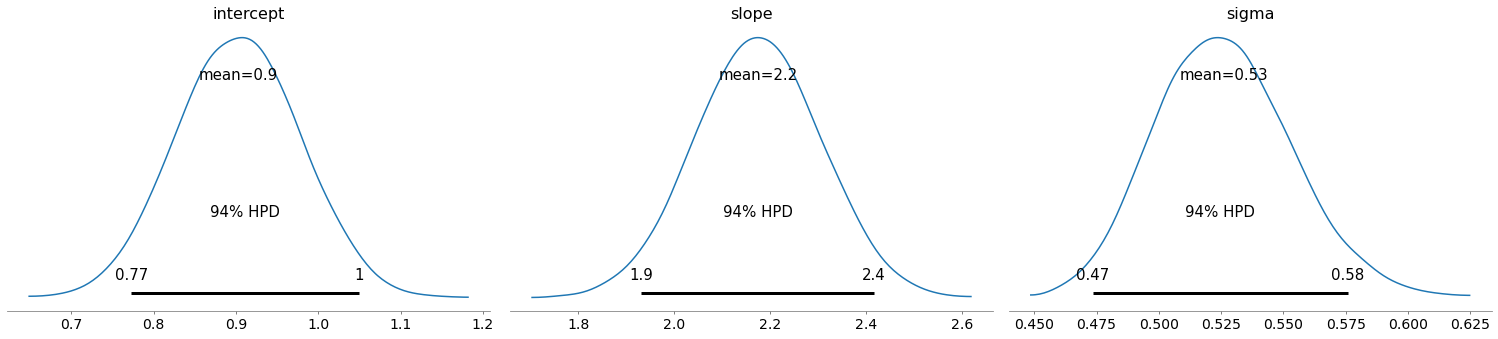

In [6]:
pm.plot_posterior(trace);

## Linear Regression for Pairs Trading
Based on Thomas Wiecki's [rolling regression](https://docs.pymc.io/notebooks/GLM-rolling-regression.html) example.

In [7]:
with pd.HDFStore('../data/assets.h5') as store:
    stock_prices = store['quandl/wiki/prices'].adj_close.unstack().loc['2000':, ].resample('M').last()
stock_returns = stock_prices.pct_change().dropna(axis=1, thresh=int(len(stock_prices)*.8))

In [8]:
stock_returns.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 219 entries, 2000-01-31 to 2018-03-31
Freq: M
Columns: 2020 entries, A to ZQK
dtypes: float64(2020)
memory usage: 3.4 MB


In [9]:
base_price = web.DataReader('SP500', data_source='fred', start='2008', end='2018-12-31')
base_price = base_price.resample('M').last().dropna().squeeze().to_frame('base')
base_returns = base_price.pct_change().dropna()
base_returns.head()

,base
DATE,
2010-05-31,-0.081976
2010-06-30,-0.053882
2010-07-31,0.068778
2010-08-31,-0.047449
2010-09-30,0.087551


In [10]:
cointegration = {}
for stock in stock_returns:
    df = base_price.join(stock_returns[[stock]]).dropna()
    _, pval, _ = coint(df.base, df[stock])
    cointegration[stock] = pval

In [11]:
cointegration = pd.Series(cointegration).sort_values(ascending=False)

In [12]:
cointegration.describe()

count    2020.000000
mean        0.980352
std         0.012008
min         0.714557
25%         0.978048
50%         0.983212
75%         0.985991
max         0.992742
dtype: float64

In [13]:
cointegration.head(10)

SMRT    0.992742
BK      0.992716
DORM    0.992432
OII     0.992355
ALGN    0.992353
FORM    0.992193
FRED    0.992154
CYBX    0.991853
GD      0.991572
MSFT    0.991547
dtype: float64

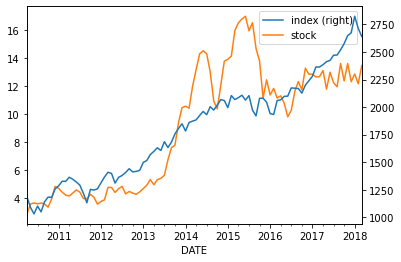

In [14]:
prices = base_price.join(stock_prices[['ESCA']]).dropna()
prices.columns = ['index', 'stock']
prices.plot(secondary_y='index');

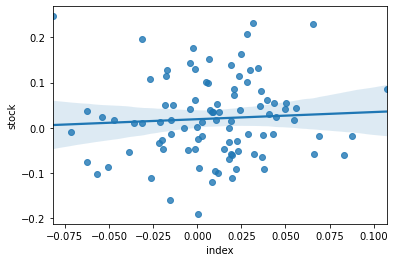

In [17]:
returns = prices.pct_change().dropna()
sns.regplot(x='index', y='stock', data=returns);

Plotting the prices over time suggests a strong correlation. However, the correlation seems to change over time.

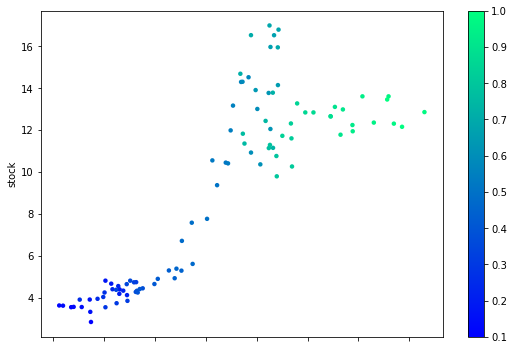

In [18]:
colors = np.linspace(0.1, 1, len(prices))
mymap = plt.get_cmap("winter")
prices.plot.scatter(x='index', y='stock', c=colors, cmap=mymap, lw=0, figsize=(9, 6));

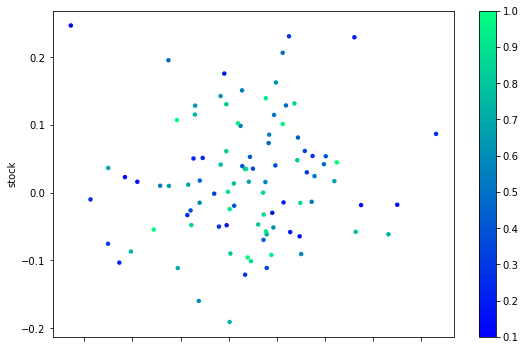

In [19]:
colors = np.linspace(0.1, 1, len(returns))
mymap = plt.get_cmap("winter")
returns.plot.scatter(x='index', y='stock', c=colors, cmap=mymap, lw=0, figsize=(9, 6));

A naive approach would be to estimate a linear model and ignore the time domain.

In [20]:
with pm.Model() as model_reg:
    pm.glm.GLM.from_formula('stock ~ index', returns)
    trace_reg = pm.sample(2000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sd, index, Intercept]
Sampling 4 chains, 0 divergences: 100%|██████████| 12000/12000 [00:02<00:00, 4740.06draws/s]


The posterior predictive plot shows how bad the fit is.

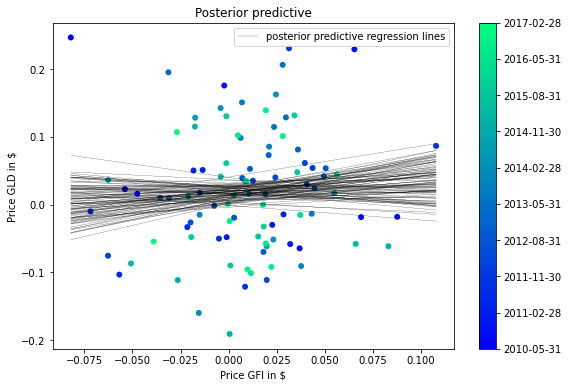

In [21]:
fig = plt.figure(figsize=(9, 6))
ax = fig.add_subplot(111, 
                     xlabel='Price GFI in \$', 
                     ylabel='Price GLD in \$',
                     title='Posterior predictive regression lines')
sc = ax.scatter(returns['index'], returns['stock'], c=colors, cmap=mymap, lw=0)
pm.plot_posterior_predictive_glm(trace_reg[100:], samples=100, 
                              label='posterior predictive regression lines',
                              lm=lambda x, sample: sample['Intercept'] + sample['index'] * x,
                              eval=np.linspace(returns['index'].min(), returns['index'].max(), 100))
cb = plt.colorbar(sc)
cb.ax.set_yticklabels([str(p.date()) for p in returns[::len(returns)//10].index]);
ax.legend(loc=0);

## Rolling regression

Next, we will build an improved model that will allow for changes in the regression coefficients over time. Specifically, we will assume that intercept and slope follow a random-walk through time. That idea is similar to the [stochastic volatility model](stochastic_volatility.ipynb).

$$ \alpha_t \sim \mathcal{N}(\alpha_{t-1}, \sigma_\alpha^2) $$
$$ \beta_t \sim \mathcal{N}(\beta_{t-1}, \sigma_\beta^2) $$

First, lets define the hyper-priors for $\sigma_\alpha^2$ and $\sigma_\beta^2$. This parameter can be interpreted as the volatility in the regression coefficients.

In [22]:
model_randomwalk = pm.Model()
with model_randomwalk:
    # std of random walk
    sigma_alpha = pm.Exponential('sigma_alpha', 50.)
    sigma_beta = pm.Exponential('sigma_beta', 50.)
    
    alpha = pm.GaussianRandomWalk('alpha', sd=sigma_alpha, 
                                  shape=len(returns))
    beta = pm.GaussianRandomWalk('beta', sd=sigma_beta, 
                                 shape=len(returns))       

Perform the regression given coefficients and data and link to the data via the likelihood.

In [23]:
with model_randomwalk:
    # Define regression
    regression = alpha + beta * returns['index']
    
    # Assume prices are Normally distributed, the mean comes from the regression.
    sd = pm.HalfNormal('sd', sd=.1)
    likelihood = pm.Normal('y', 
                           mu=regression, 
                           sd=sd, 
                           observed=returns.stock)

Inference. Despite this being quite a complex model, NUTS handles it wells.

In [25]:
with model_randomwalk:
    trace_rw = pm.sample(tune=2000, 
                         cores=4, 
                         draws=200, 
                         nuts_kwargs=dict(target_accept=.9))

Only 200 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sd, beta, alpha, sigma_beta, sigma_alpha]
Sampling 4 chains, 199 divergences: 100%|██████████| 8800/8800 [03:38<00:00, 40.31draws/s]
The chain contains only diverging samples. The model is probably misspecified.
The acceptance probability does not match the target. It is 3.8847983582126506e-27, but should be close to 0.9. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8189082679003202, but should be close to 0.9. Try to increase the number of tuning steps.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The acceptance probability does not match the target. It is 0.7637691378826945, but should be close to 0.9. Try to increase the number of tuning steps.
The chain reached the maximum tree depth. Increase max_treedepth, i

Increasing the tree-depth does indeed help but it makes sampling very slow. The results look identical with this run, however.

## Analysis of results

As can be seen below, $\alpha$, the intercept, changes over time.

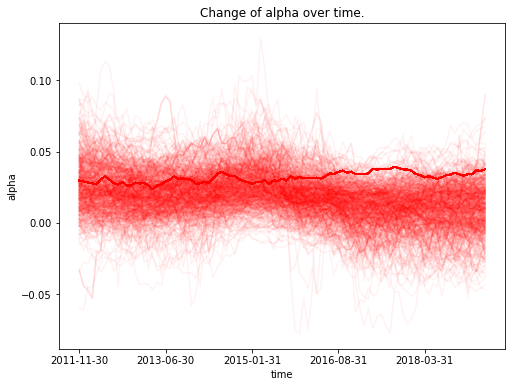

In [26]:
fig = plt.figure(figsize=(8, 6))
ax = plt.subplot(111, xlabel='time', ylabel='alpha', title='Change of alpha over time.')
ax.plot(trace_rw['alpha'].T, 'r', alpha=.05);
ax.set_xticklabels([str(p.date()) for p in prices[::len(prices)//5].index]);

As does the slope.

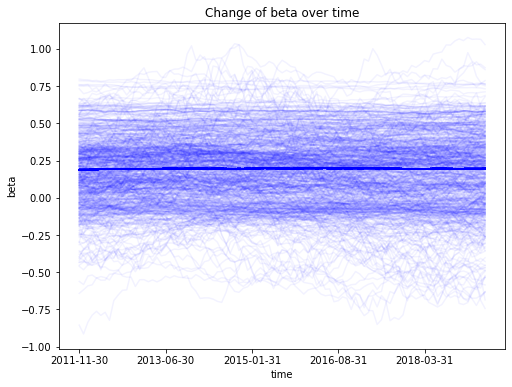

In [27]:
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, xlabel='time', ylabel='beta', title='Change of beta over time')
ax.plot(trace_rw['beta'].T, 'b', alpha=.05);
ax.set_xticklabels([str(p.date()) for p in prices[::len(prices)//5].index]);

The posterior predictive plot shows that we capture the change in regression over time much better. Note that we should have used returns instead of prices. The model would still work the same, but the visualisations would not be quite as clear.

AttributeError: 'DataFrame' object has no attribute 'GFI'

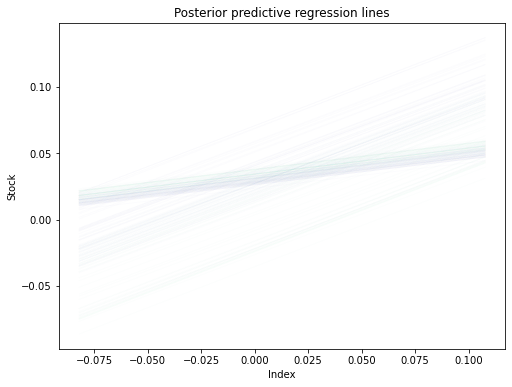

In [29]:
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, xlabel='Index', ylabel='Stock', 
            title='Posterior predictive regression lines')

colors = np.linspace(0.1, 1, len(returns))
colors_sc = np.linspace(0.1, 1, len(trace_rw[::10]['alpha'].T))
mymap = plt.get_cmap('winter')
mymap_sc = plt.get_cmap('winter')

xi = np.linspace(returns['index'].min(), returns['index'].max(), 50)
for i, (alpha, beta) in enumerate(zip(trace_rw[::15]['alpha'].T, 
                                      trace_rw[::15]['beta'].T)):
    for a, b in zip(alpha[::30], beta[::30]):
        ax.plot(xi, a + b*xi, alpha=.01, lw=1, 
                c=mymap_sc(colors_sc[i]))
        
sc = ax.scatter(prices_zscored.GFI, prices_zscored.GLD, 
                label='data', cmap=mymap, c=colors)
cb = plt.colorbar(sc)
cb.ax.set_yticklabels([str(p.date()) for p in prices_zscored[::len(prices)//10].index]);
#ax.set(ylim=(100, 190));